In [1]:
import numpy as np
import os
import time
import scipy
import glob

from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib

import pandas as pd
from scipy.stats import binned_statistic_2d
import utils as util
import behavior as butil

In [2]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

In [3]:
util.set_sns_style(style='dark')

## load data

In [4]:
root_dir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
#experiment = 'Spontaneous_edge_tracking'
experiment = 'hdeltac/csv'
# experiment = 'hdeltac'
# 'hdeltac/csv/20220517_hdc_split_60d05_sytgcamp7f'
src_dir = os.path.join(root_dir, experiment)
# src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
print(src_dir)

/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/hdeltac/csv


In [5]:
log_files = sorted(glob.glob(os.path.join(src_dir, '2022*', 'et', '*.csv')), \
                   key=util.natsort)
#log_files = sorted(glob.glob(os.path.join(src_dir, '*.log')), key=util.natsort)
print("Found {} raw .log behavior files.".format(len(log_files)))

for fi, fpath in enumerate(log_files):
    dfn = fpath.split('/hdeltac/csv/')[1].split('/et')[0]
    print(fi, dfn)

Found 7 raw .log behavior files.
0 20220517_hdc_split_60d05_sytgcamp7f
1 20220627_hdc_split_Fly1
2 20220627_hdc_split_Fly2
3 20220628_HDC_sytjGCaMP7f_Fly1
4 20220628_HDC_sytjGCaMP7f_Fly1_45-004
5 20220629_HDC_split_sytjGCaMP7f_Fly1
6 20220629_HDC_split_sytjGCaMP7f_Fly3


In [6]:
%matplotlib notebook

# plot trajectories

In [7]:
excluded = ['20220628_HDC_sytjGCaMP7f_Fly1_45-004']

<IPython.core.display.Javascript object>


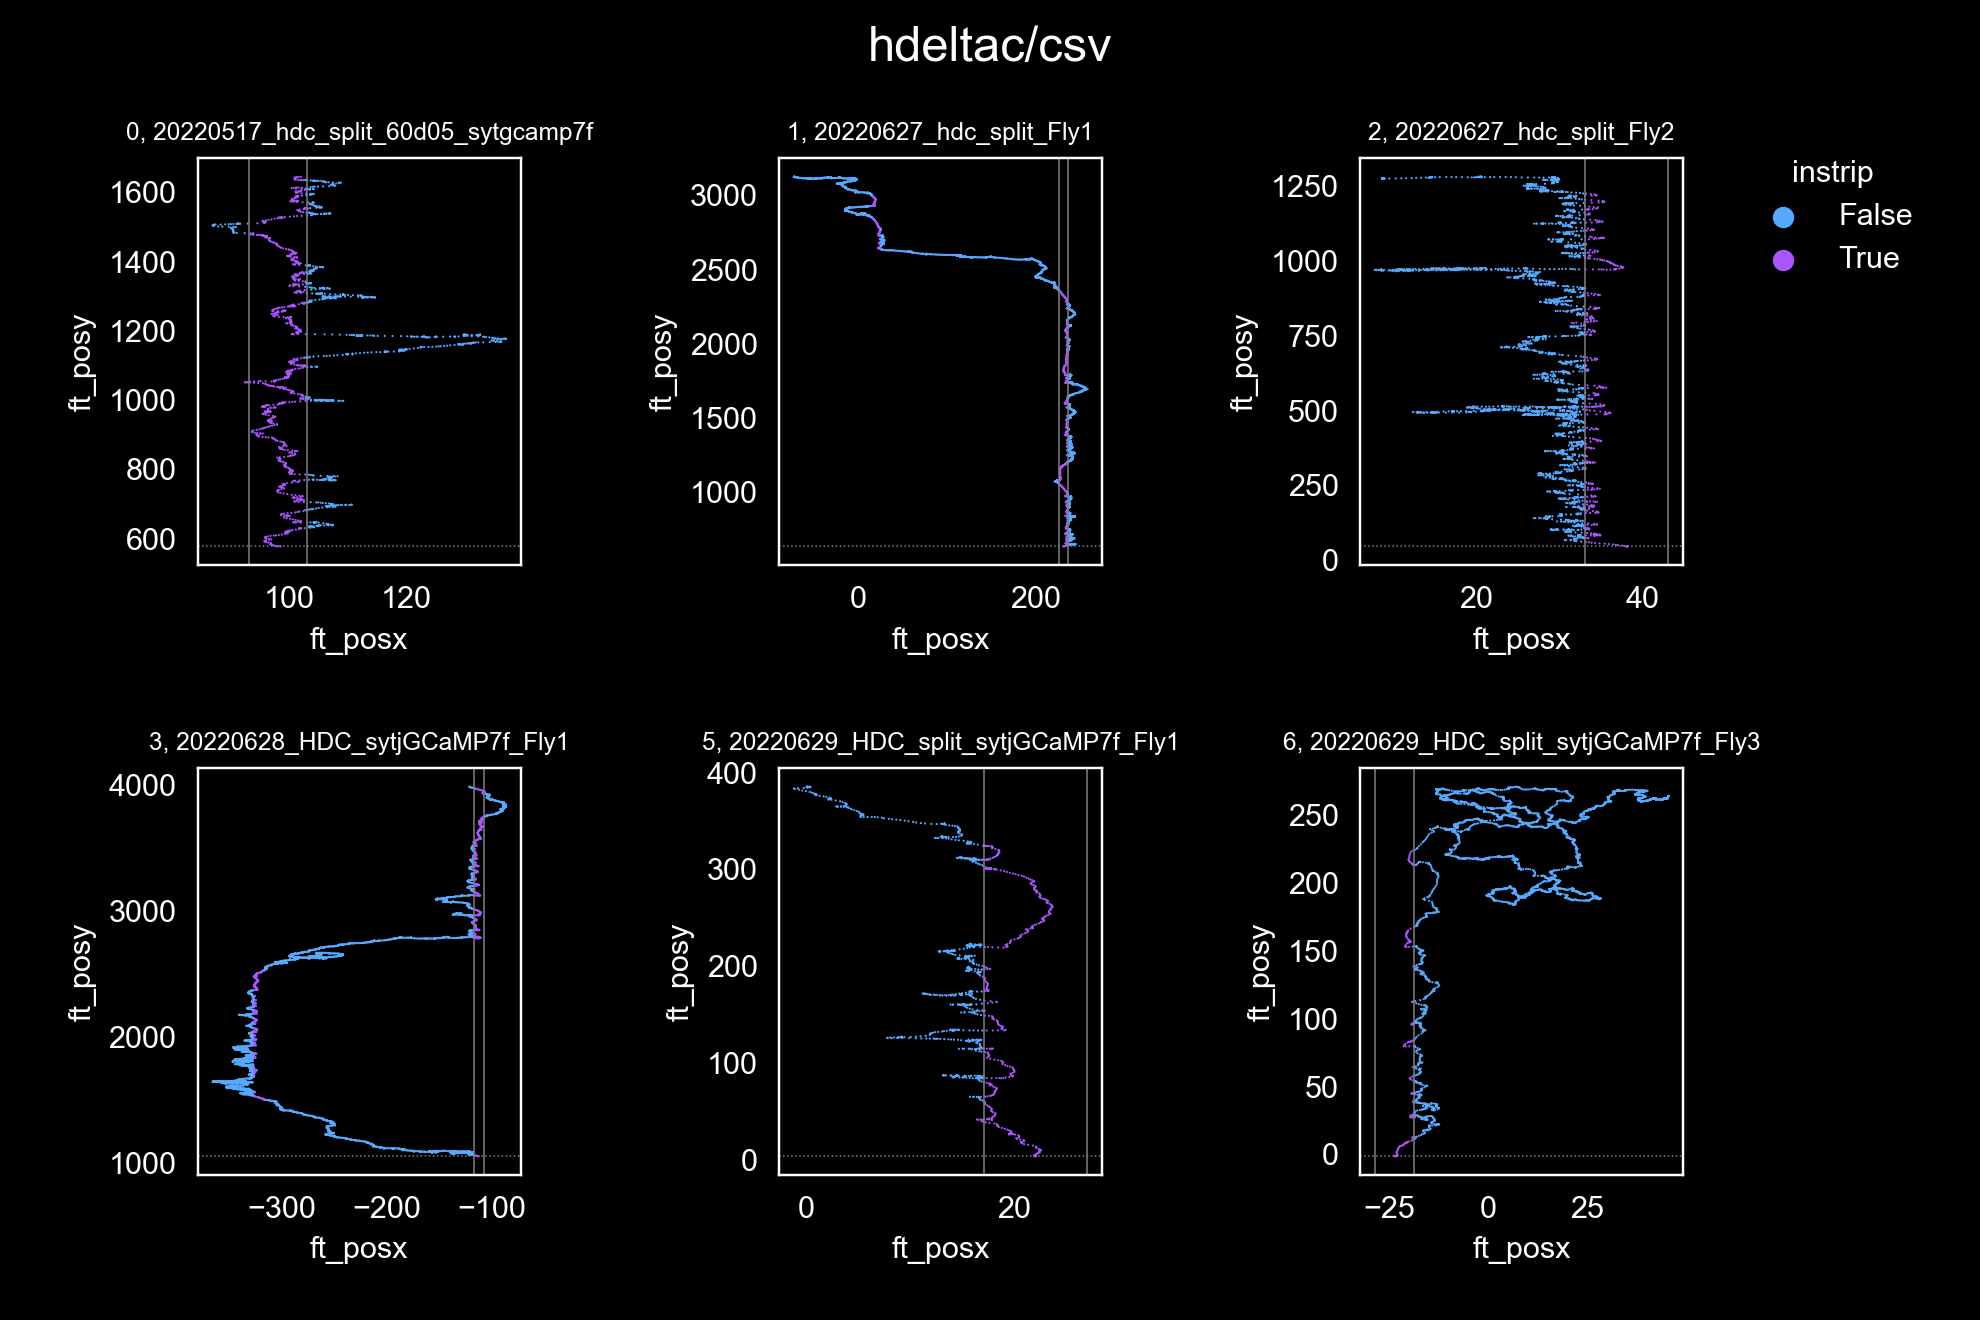

Text(0.5, 0.98, 'hdeltac/csv')

In [8]:
hue_varname='instrip'
palette='cool'
is_csv = True
start_at_odor = True
odor_width=10
odor_lc='lightgray'
odor_lw=0.5
nrows = 2
ncols = 3

xmin, xmax = (-500, 500)
ymin, ymax = (-100, 1000)
odor_xmin, odor_xmax = (-100, 100)
fig, axes = pl.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(ncols*3, nrows*3))
ai = 0
for fi, fpath in enumerate(log_files):
    # load data
    if is_csv:
        df0 = butil.load_dataframe_resampled_csv(fpath)
    else:
        df0 = butil.load_dataframe(fpath) 
    if df0 is None:
        print("error:", fn)
        continue
    #odor params
    odor_params = butil.get_odor_params(df0, odor_width=odor_width)
    odor_xmin, odor_xmax = odor_params['odor_boundary']
    odor_start_posx, odor_start_posy = odor_params['odor_start_pos']
    plotdf = df0[df0['time']>=odor_params['odor_start_time']] if start_at_odor else df0
    # set subplot
    #fn = os.path.splitext(os.path.split(fpath)[-1])[0]
    dfn = fpath.split('/hdeltac/csv/')[1].split('/et')[0]
    if dfn in excluded:
        continue
    title = '{}, {}'.format(fi, dfn)
    ax = axes.flat[ai]
    ax.set_title(title, fontsize=8)
    # plot
    sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue=hue_varname,
                    palette=palette, s=0.5, ax=ax, linewidth=0, alpha=1) #'none')
    ax.get_legend().remove()
    # add odor corridor
    #butil.center_odor_path(ax, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax,
                    odor_start_posy=odor_start_posy)
    ai+=1
# remove unused axes
for ix in np.arange(fi+1, nrows*ncols):
    axes.flat[ix].axis('off')
# legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.9), ncol=1,
           loc='upper right', title=hue_varname, frameon=False) 
# adjust plots
pl.subplots_adjust(hspace=0.5, wspace=0.8, left=0.1, right=0.85)
fig.suptitle(experiment, fontsize=16)

# individual 

In [9]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [10]:
fpath = log_files[3]
dfn = fpath.split('/hdeltac/csv/')[1].split('/et')[0]
print(dfn)
df0 = butil.load_dataframe_resampled_csv(fpath)
# Get odor params 
odor_width =10
odor_params = butil.get_odor_params(df0, odor_width=odor_width)
odor_xmin, odor_xmax = odor_params['odor_boundary']
odor_start_posx, odor_start_posy = odor_params['odor_start_pos']
trial_start_time = odor_params['trial_start_time']
odor_start_time = odor_params['odor_start_time']

20220628_HDC_sytjGCaMP7f_Fly1


In [11]:
df = df0[df0['time']>=odor_start_time].copy()

In [12]:
# parse in and out bouts
df = butil.parse_bouts(df, count_varname='instrip', bout_varname='boutnum') # 1-count
# filter in and out bouts by min. duration 
bout_thresh=0.5
df = butil.filter_bouts_by_dur(df, bout_thresh=bout_thresh, bout_varname='boutnum', 
                        count_varname='instrip', verbose=False)
# check if any too short
boutdurs = butil.get_bout_durs(df, bout_varname='boutnum')
too_short = [k for k, v in boutdurs.items() if v<0.5]
assert len(too_short)==0, "Bad filtering, still have {} too-short bouts".format(len(too_short))

#### identify grid

In [13]:
grid_sep=200
ogrid = butil.get_odor_grid(df, odor_width=odor_width, grid_sep=grid_sep,
                           use_crossings=True, verbose=False)

got both
got both
got both


<IPython.core.display.Javascript object>


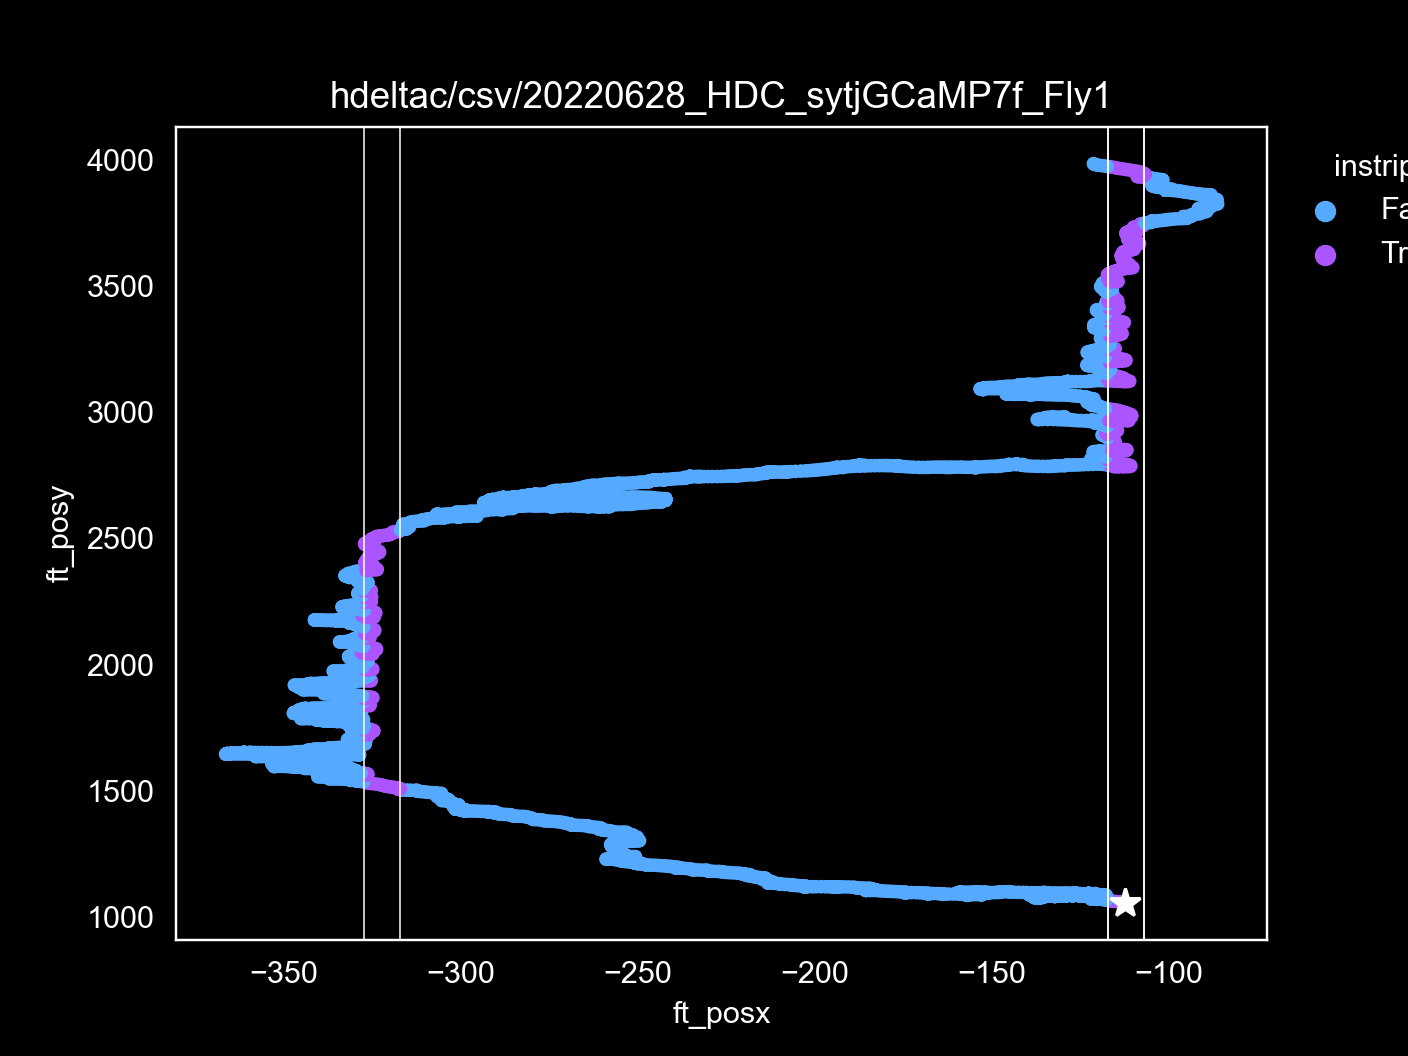

Text(0.5, 1.0, 'hdeltac/csv/20220628_HDC_sytjGCaMP7f_Fly1')

In [14]:
plotdf = df[df['time']>=odor_start_time]
# --------------------------------------------------------
fig, ax = pl.subplots()
sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue='instrip', palette=palette,
               s=20, ax=ax, edgecolor='none')
ax.plot(odor_start_posx, odor_start_posy, 'w*', markersize=10) 
for cnum, (odor_xmin, odor_xmax) in ogrid.items():
    ax.axvline(x=odor_xmin, c='w', lw=odor_lw) 
    ax.axvline(x=odor_xmax, c='w', lw=odor_lw) 
ax.legend(bbox_to_anchor=(1,1), loc='upper left', title=hue_varname, frameon=False)
ax.set_title('{}/{}'.format(experiment, dfn))

# speed

In [15]:
## calculate instantaneous vel
window_size=53
df = butil.calculate_speed(df, smooth=True, window_size=window_size, return_same=True)
df['dist'] = np.linalg.norm(df[['ft_posx', 'ft_posy']].diff(axis=0), axis=1)

In [16]:
tsteps = df['time'].diff()
# fig, ax = pl.subplots()
# sns.histplot(df['time'], ax=ax)
print('Time steps: {:.2f}-{:.2f} sec'.format(tsteps.min(), tsteps.max()))

Time steps: 0.09-0.11 sec


In [17]:
plot_smoothed_timeseries = False
if plot_smoothed_timeseries:
    fig, ax = pl.subplots(figsize=(8,4))
    ax.plot(df['cum_time'], df['speed'], color='gray', lw=0.5) #, name='raw')
    ax.plot(df['cum_time'], df['smoothed_speed'], 'r', lw=1)

<IPython.core.display.Javascript object>


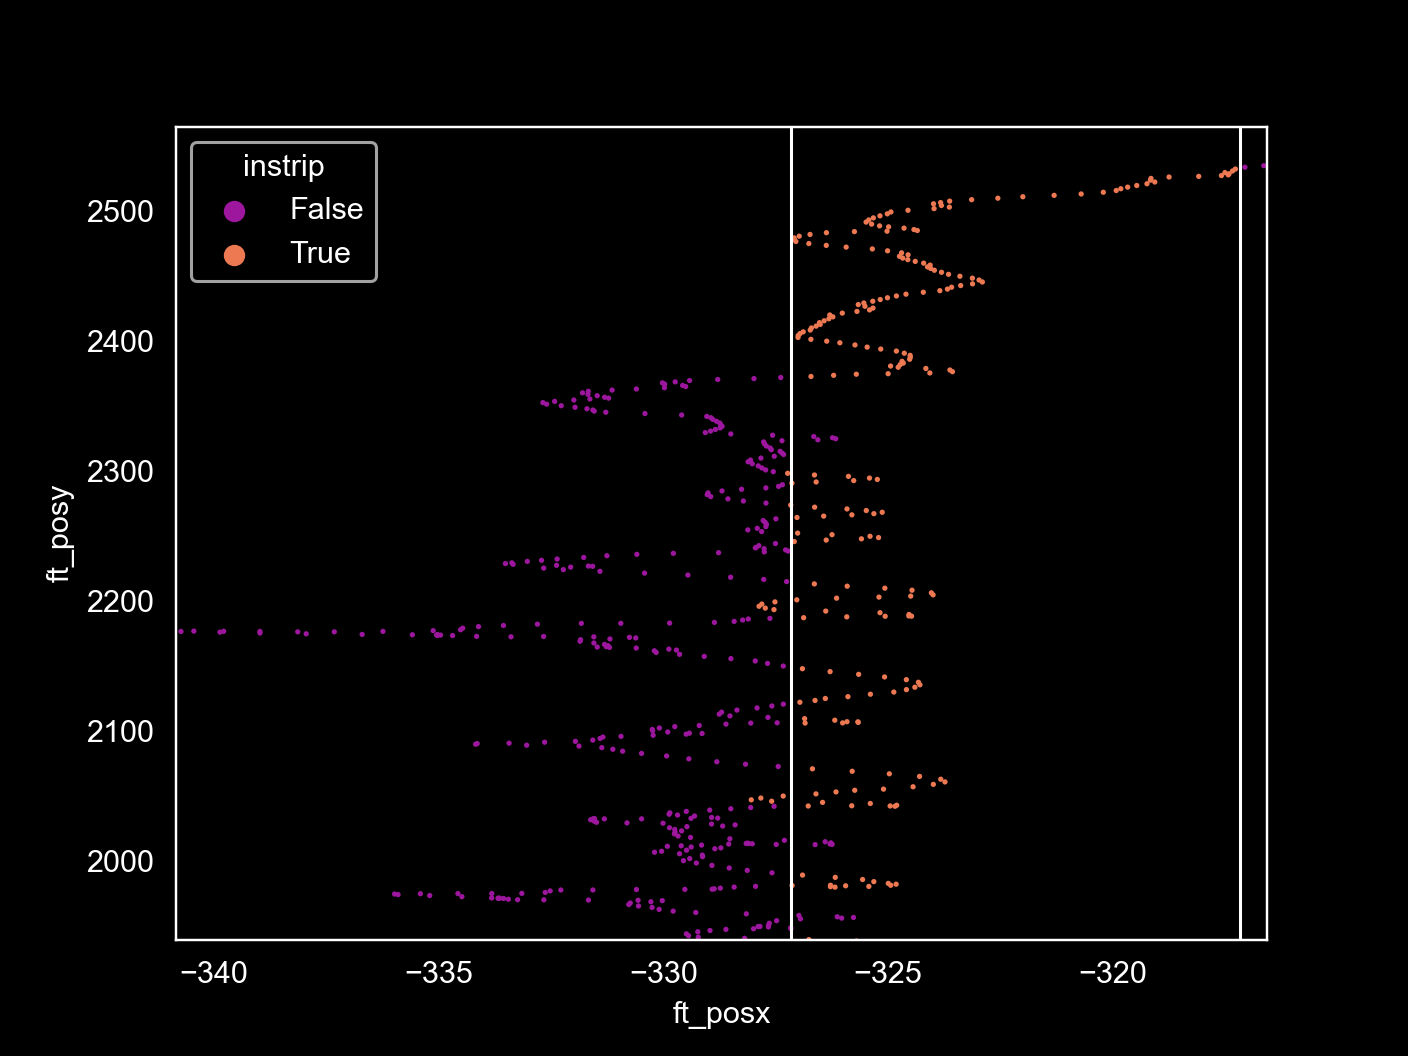

In [21]:
plotdf = df[df['time']>=odor_start_time].copy()
hue_var = 'instrip' #'smoothed_speed'
colorscale='magma'
colorscale_title = 'Inst speed (mm/s)' if hue_var=='smoothed_speed' else ''

fig, ax = pl.subplots()
sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue=hue_var, s=3,
                palette='plasma', ax=ax, edgecolor='none')
for cnum, (odor_xmin, odor_xmax) in ogrid.items():
    butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax, \
                               odor_linecolor='white', odor_linewidth=1,
                               odor_start_posy=odor_start_posy)
# butil.center_odor_path(ax)

# calculate stops

In [22]:
# Calculate stops
stop_thresh = 1.0
df = butil.calculate_stops(df, stop_thresh=stop_thresh, speed_varname='smoothed_speed')
df = butil.filter_bouts_by_dur(df, bout_thresh=0.1, bout_varname='stopbout', 
                        count_varname='stopped', verbose=True)
nstops = len(df[df['stopped']==True]['stopbout'].unique())
nstops

Found 1 bouts too short (thr=0.10 sec)


15

In [23]:
# stopbout_durs = butil.get_bout_durs(df[df['stopped']], bout_varname='stopbout')
stopdurs = butil.get_bout_durs(df[df['stopped']], bout_varname='stopbout')
# Get durs & dists
stopbouts = pd.DataFrame(data=stopdurs.values(), index=stopdurs.keys(), 
                        columns=['duration'])
stopbouts['instrip'] = [df[df['stopbout']==i]['instrip'].unique()[0] for i in stopbouts.index.tolist()]
stopbouts['boutnum'] = [df[df['stopbout']==i]['boutnum'].unique()[0] for i in stopbouts.index.tolist()]
stopbouts['distance'] = None
for k, v in stopdurs.items():
    df_ = df[(df['stopped']) & (df['stopbout']==k)]
    stopbouts.loc[k, 'distance'] = df_['dist'].sum()

In [24]:
window_size=5
df['smoothed_x'] = util.smooth_timecourse(df['ft_posx'], window_size)
df['smoothed_y'] = util.smooth_timecourse(df['ft_posy'], window_size)


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_32257/4263135747.py:14: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for boutnum, df_ in plotdf[~plotdf['instrip']].groupby(['boutnum']):


<IPython.core.display.Javascript object>


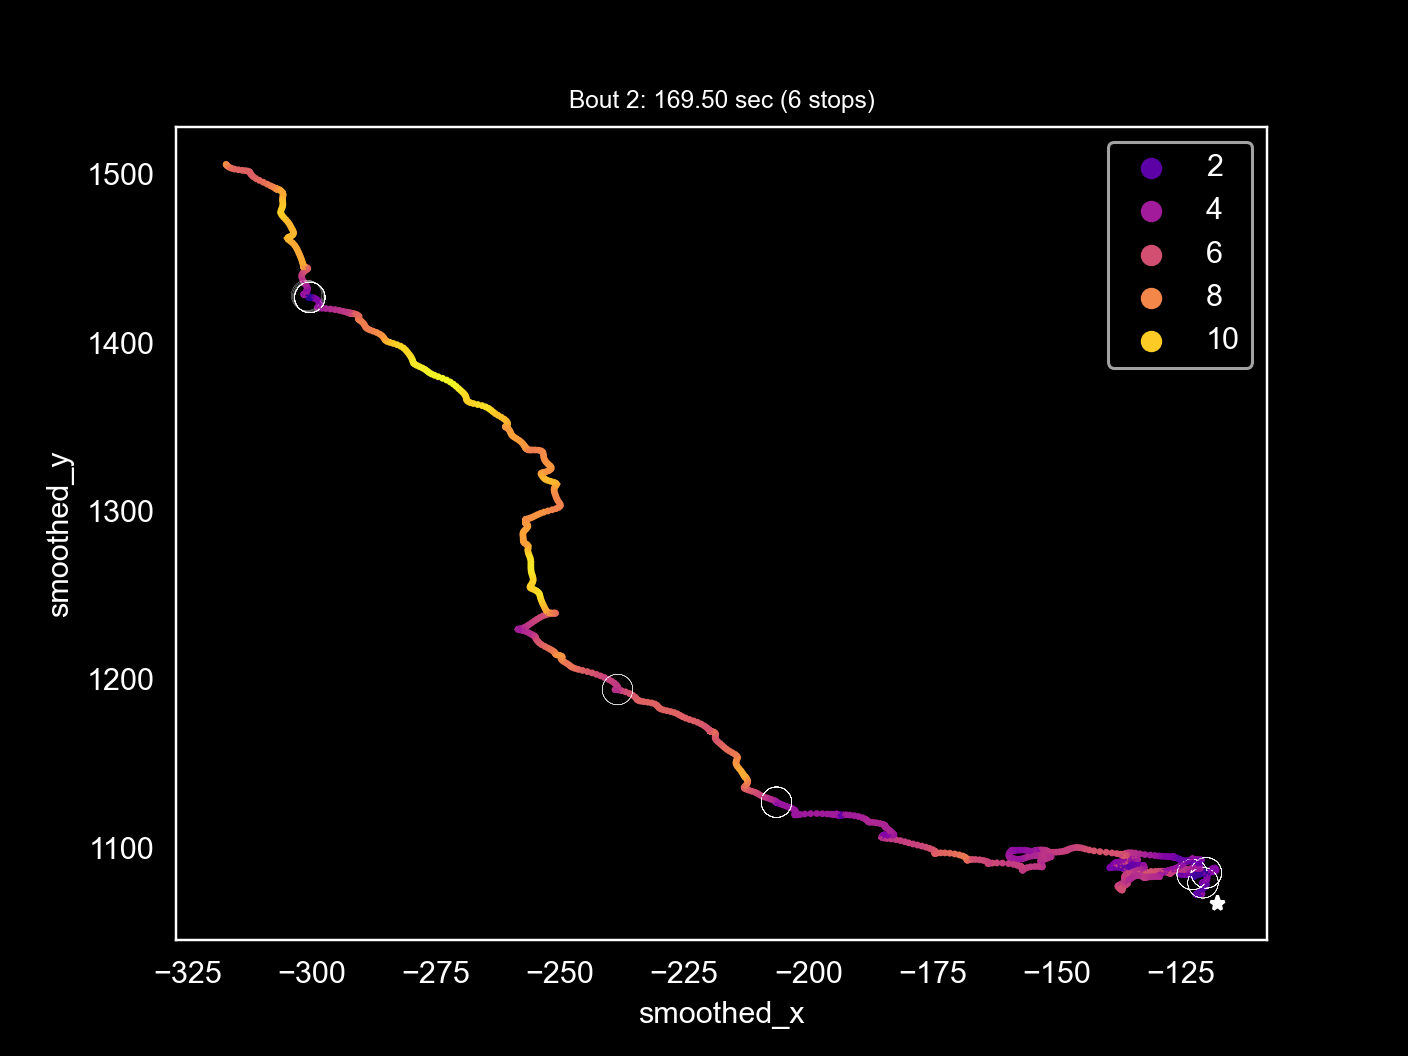

<IPython.core.display.Javascript object>


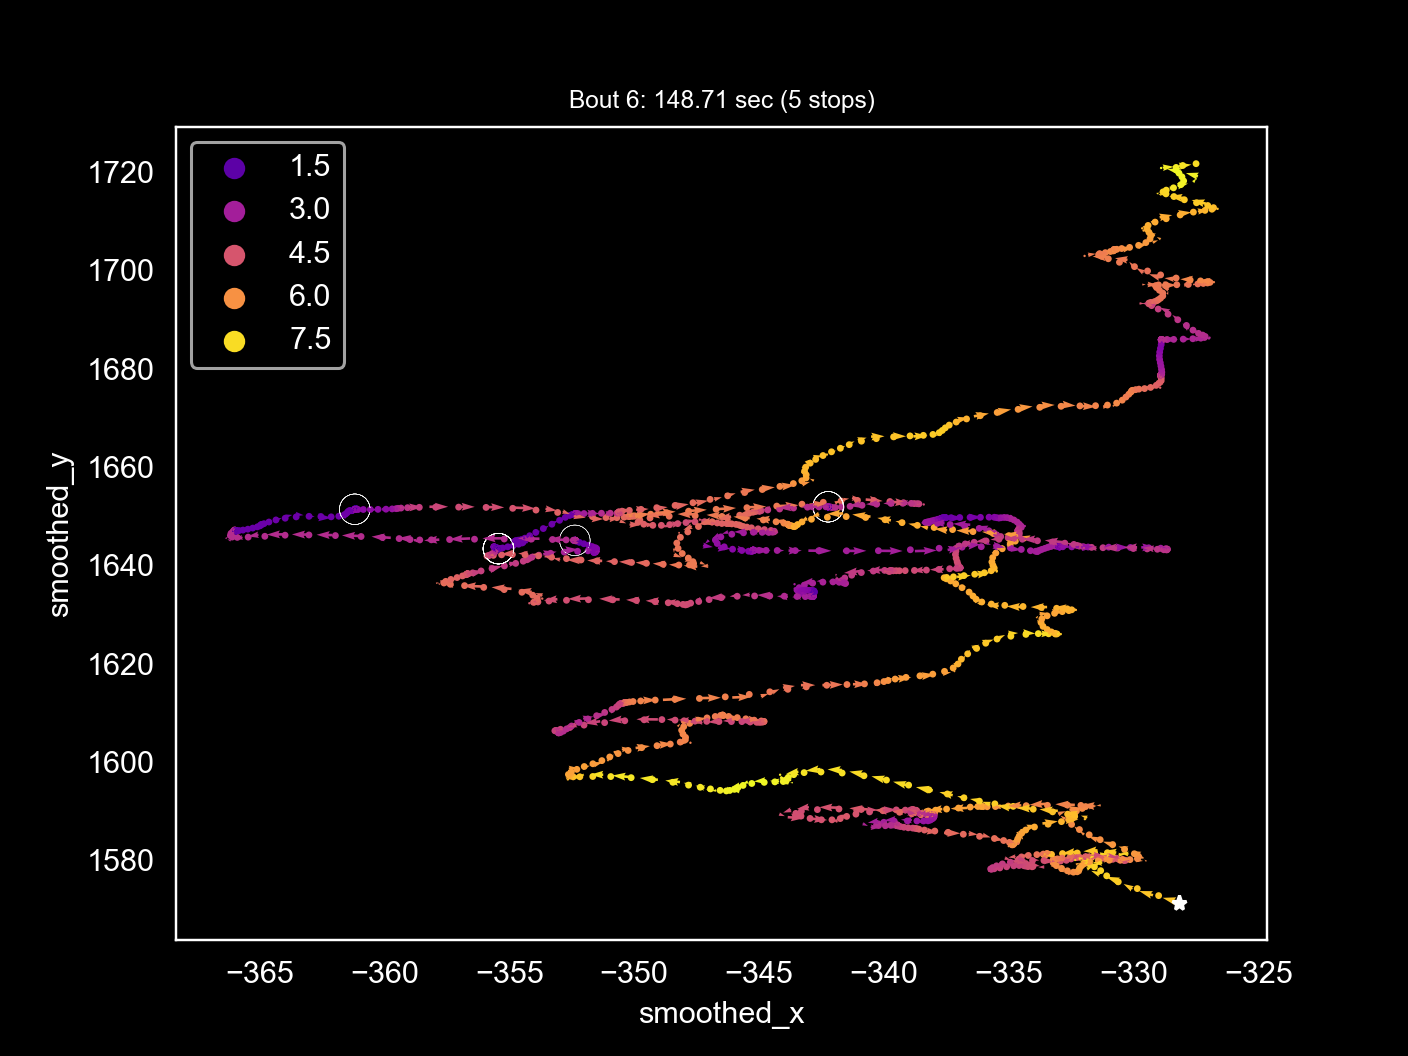

<IPython.core.display.Javascript object>


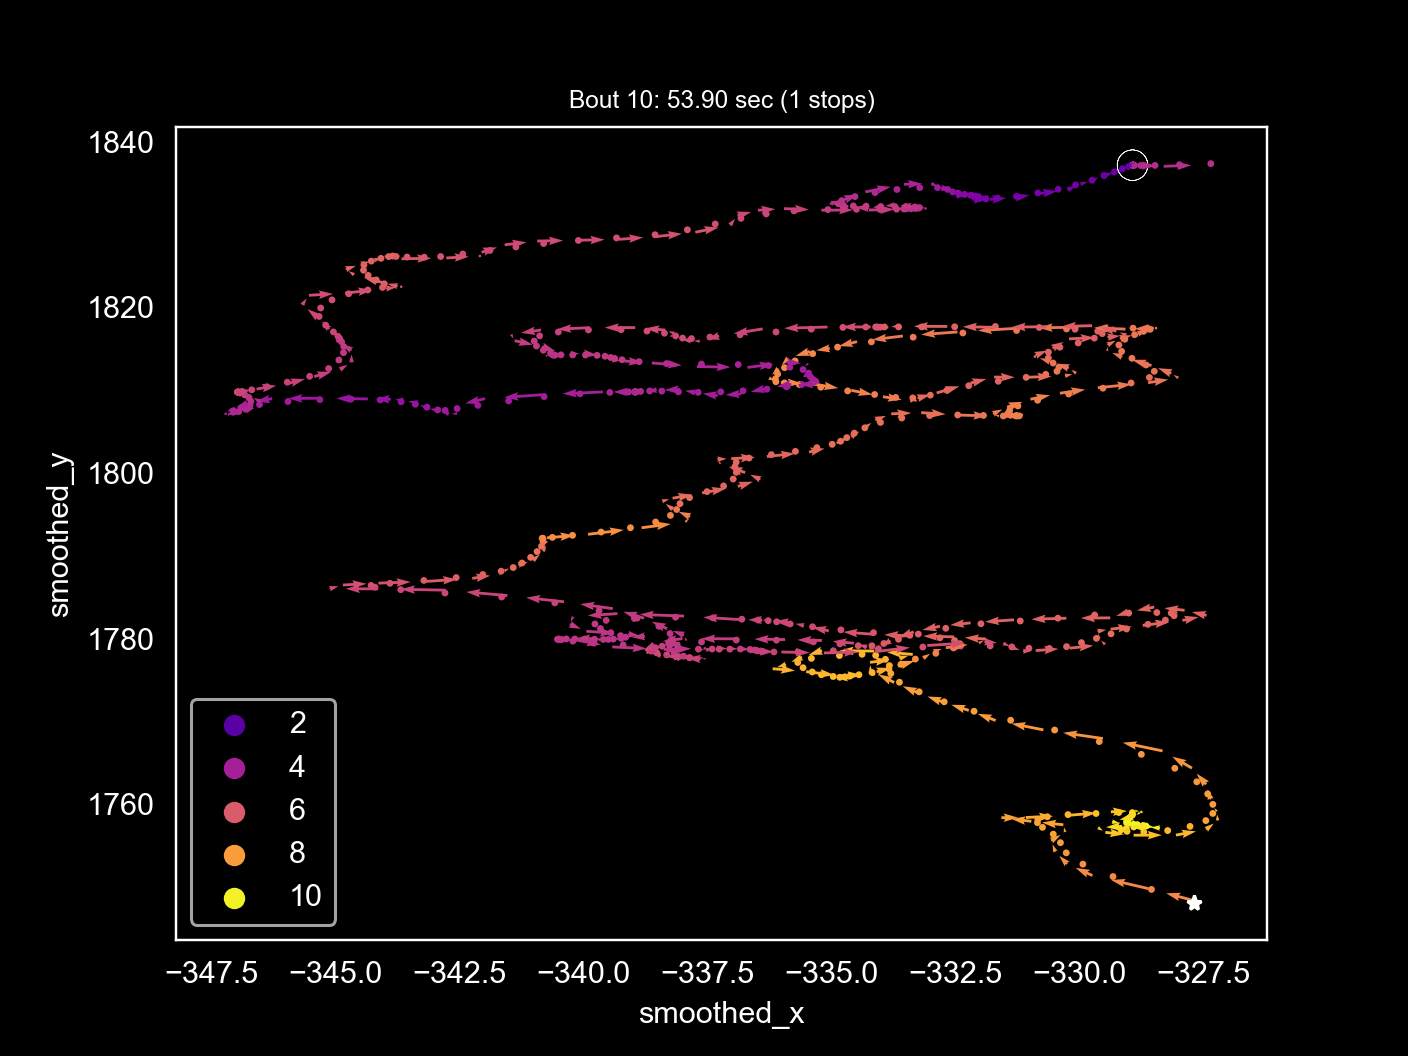

<IPython.core.display.Javascript object>


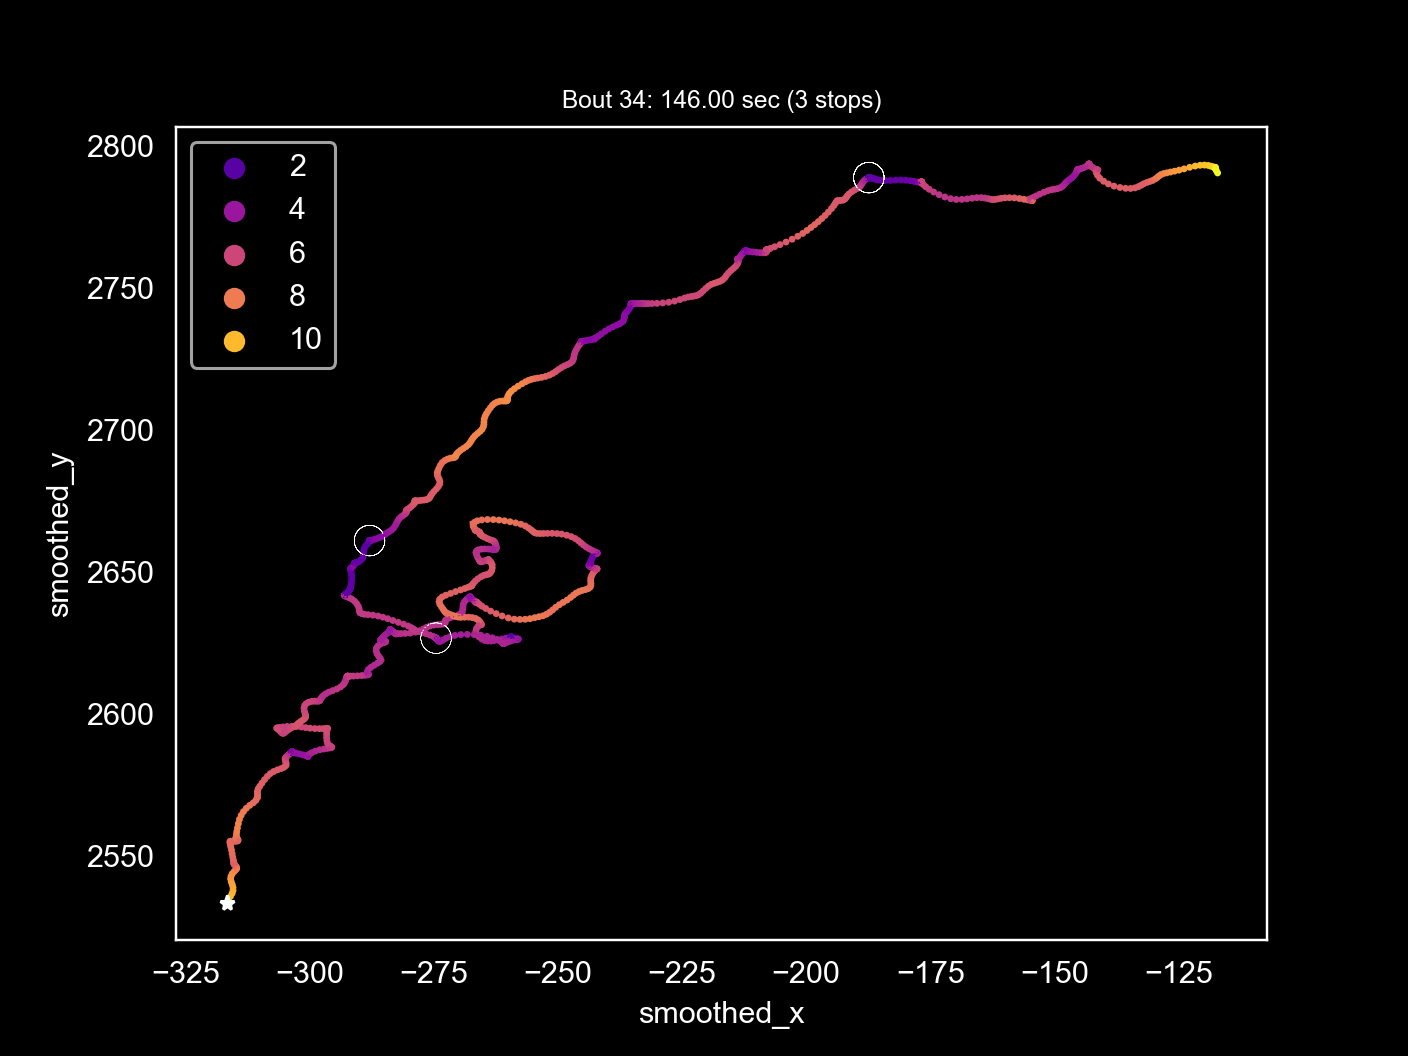

In [25]:
stop_lc='white'
xvar='smoothed_x'
yvar='smoothed_y'
hue_param='smoothed_speed'
global_colorscale=False
colormap = mpl.cm.plasma
plotdf = df[df['time']>=odor_params['odor_start_time']].copy()

if global_colorscale:
    colors=df[hue_param]
    vmin, vmax = df[~df['instrip']][hue_param].min(), df[~df['instrip']][hue_param].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# ------
for boutnum, df_ in plotdf[~plotdf['instrip']].groupby(['boutnum']):
    # how many stops
    if boutnum not in stopbouts['boutnum'].values: #nstops == 0:
        continue
    nstops = stopbouts[stopbouts['boutnum']==boutnum].shape[0]
    colors=df_[hue_param]
    if not global_colorscale:
        vmin, vmax = df_[hue_param].min(), df_[hue_param].max()
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        
    fig, ax  = pl.subplots() #figsize=(8,8))
    ax.set_title('Bout {}: {:.2f} sec ({} stops)'\
                 .format(boutnum, boutdurs[boutnum], nstops), fontsize=8)
    # Plot points
    sns.scatterplot(data=df_, x=xvar, y=yvar, hue=hue_param, 
                   palette='plasma', ax=ax, s=5, edgecolor='none')
    # Plot stop point(s)
    sns.scatterplot(data=df_[df_['stopped']], x=xvar, y=yvar, color='white', 
                    marker='o', ax=ax, s=100, edgecolor='white', linewidth=.1, facecolor='none')
    #uu = df_[xvar].shift(periods=-1) - df_[xvar]
    #vv = df_[yvar].shift(periods=-1) - df_[yvar]
    x, y, u, v = butil.get_quiverplot_inputs(df_)
    ax.quiver(x, y, u, v, color=colormap(norm(colors)), 
              angles='xy', scale_units='xy', scale=1.5)
    ax.plot(df_.iloc[0][xvar], df_.iloc[0][yvar], color='white', 
                    marker='*', markersize=5)

In [700]:
# window_size=5
# df['smoothed_x'] = util.smooth_timecourse(df['ft_posx'], window_size)
# df['smoothed_y'] = util.smooth_timecourse(df['ft_posy'], window_size)


<IPython.core.display.Javascript object>


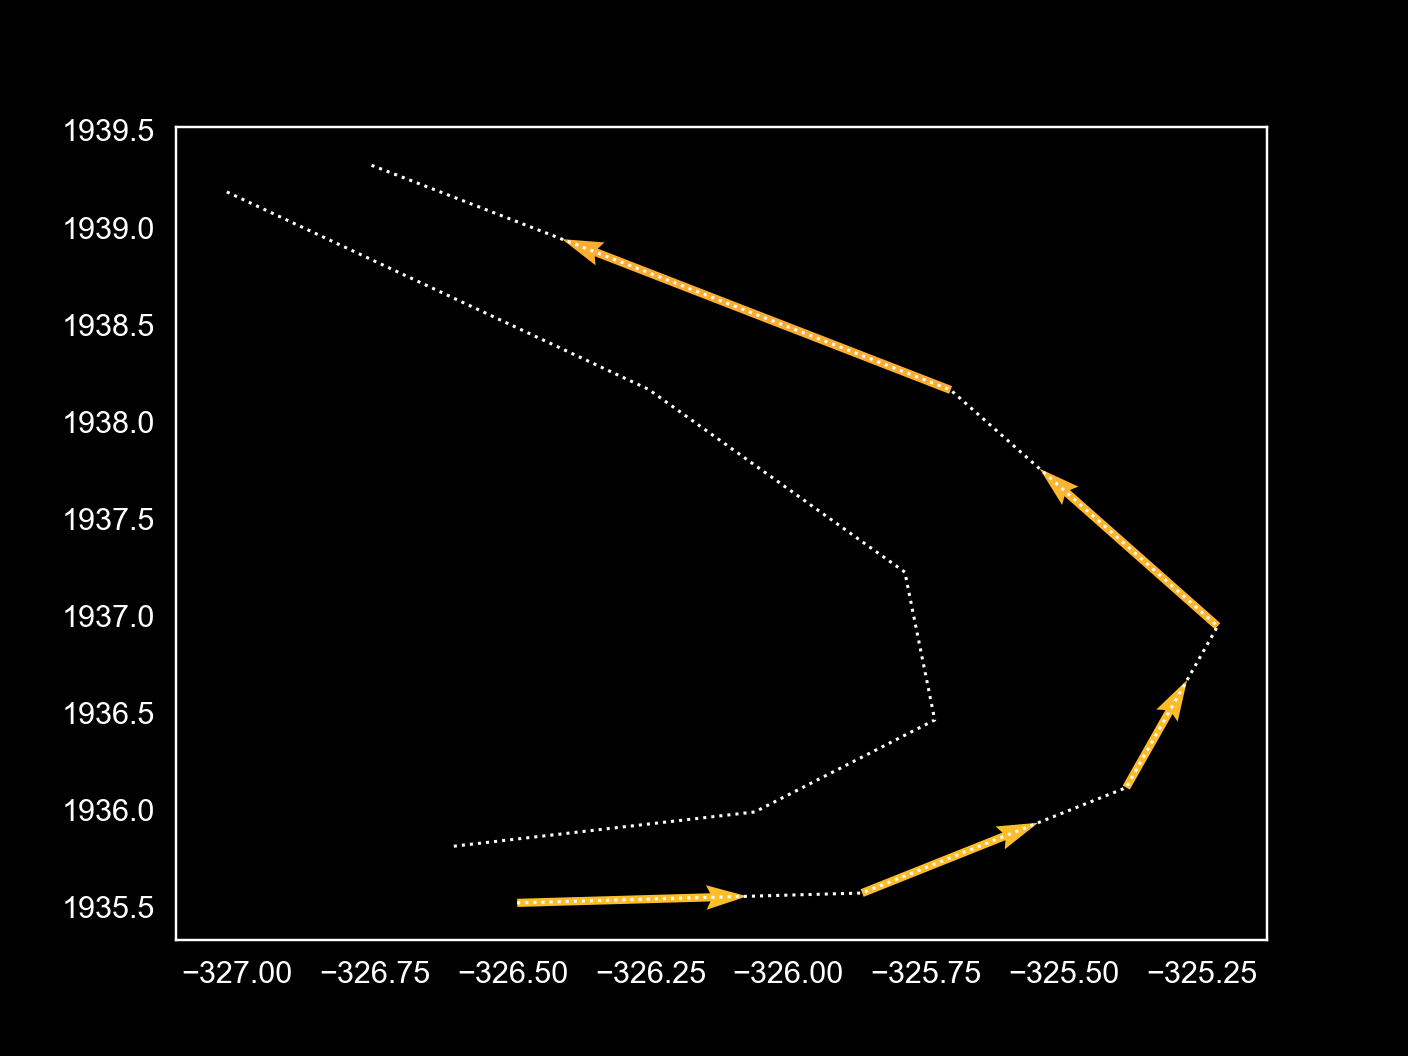

In [29]:
boutnum = 15
df_ = df.groupby(['boutnum']).get_group(boutnum)
fig, ax =pl.subplots()
uu = df_['ft_posx'].shift(periods=-1) - df_['ft_posx']
vv = df_['ft_posy'].shift(periods=-1) - df_['ft_posy']
ax.quiver(df_['ft_posx'].values, df_['ft_posy'].values, uu, vv, color=colormap(norm(colors)), 
          angles='xy', scale_units='xy', scale=1.5)
#ax.plot(df_['smoothed_x'] ,df_['smoothed_y'], lw=0.5, color='w')
ax.plot(df_['smoothed_x'] ,df_['smoothed_y'], lw=1, color='w', ls=':')
ax.plot(df_['ft_posx'] ,df_['ft_posy'], lw=1, color='w', ls=':')

# turning

In [59]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [117]:
df['heading_angle'] = np.arctan2(np.gradient(df['ft_posy']),\
                                            np.gradient(df['ft_posx']))
df['heading_angle_deg'] = np.rad2deg(df['heading_angle'])

flip_ix = df[df['heading_angle'] < 0].index.tolist()
# flipped_ang = df.loc[flip_ix, 'heading_angle'] % 360.
df['heading_angle_cont'] = df['heading_angle'].copy()
df.loc[flip_ix, 'heading_angle_cont'] = df.loc[flip_ix, 'heading_angle'] % (2*np.pi)

df['heading_angle_deg_cont'] = df['heading_angle_deg'].copy()
df.loc[flip_ix, 'heading_angle_deg_cont'] = df.loc[flip_ix, 'heading_angle_deg'] % 360.

In [118]:
#df = butil.calculate_turn_angle(df)
#df['turn_angle_deg'] = np.rad2deg(df['turn_angle'])
theta_units='rad'
use_cont=True
if theta_units=='deg':
    heading_var = 'heading_angle_deg'
    theta_range = (0, 360) if use_cont else (-180, 180) # (-np.pi, np.pi)
else:
    heading_var = 'heading_angle'
    theta_range = (0, 2*np.pi) if use_cont else (-np.pi, np.pi) 
    
heading_var_cont = '{}_cont'.format(heading_var)    
theta_norm = mpl.colors.Normalize(theta_range[0], theta_range[1])
theta_range

(0, 6.283185307179586)

In [119]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

<IPython.core.display.Javascript object>


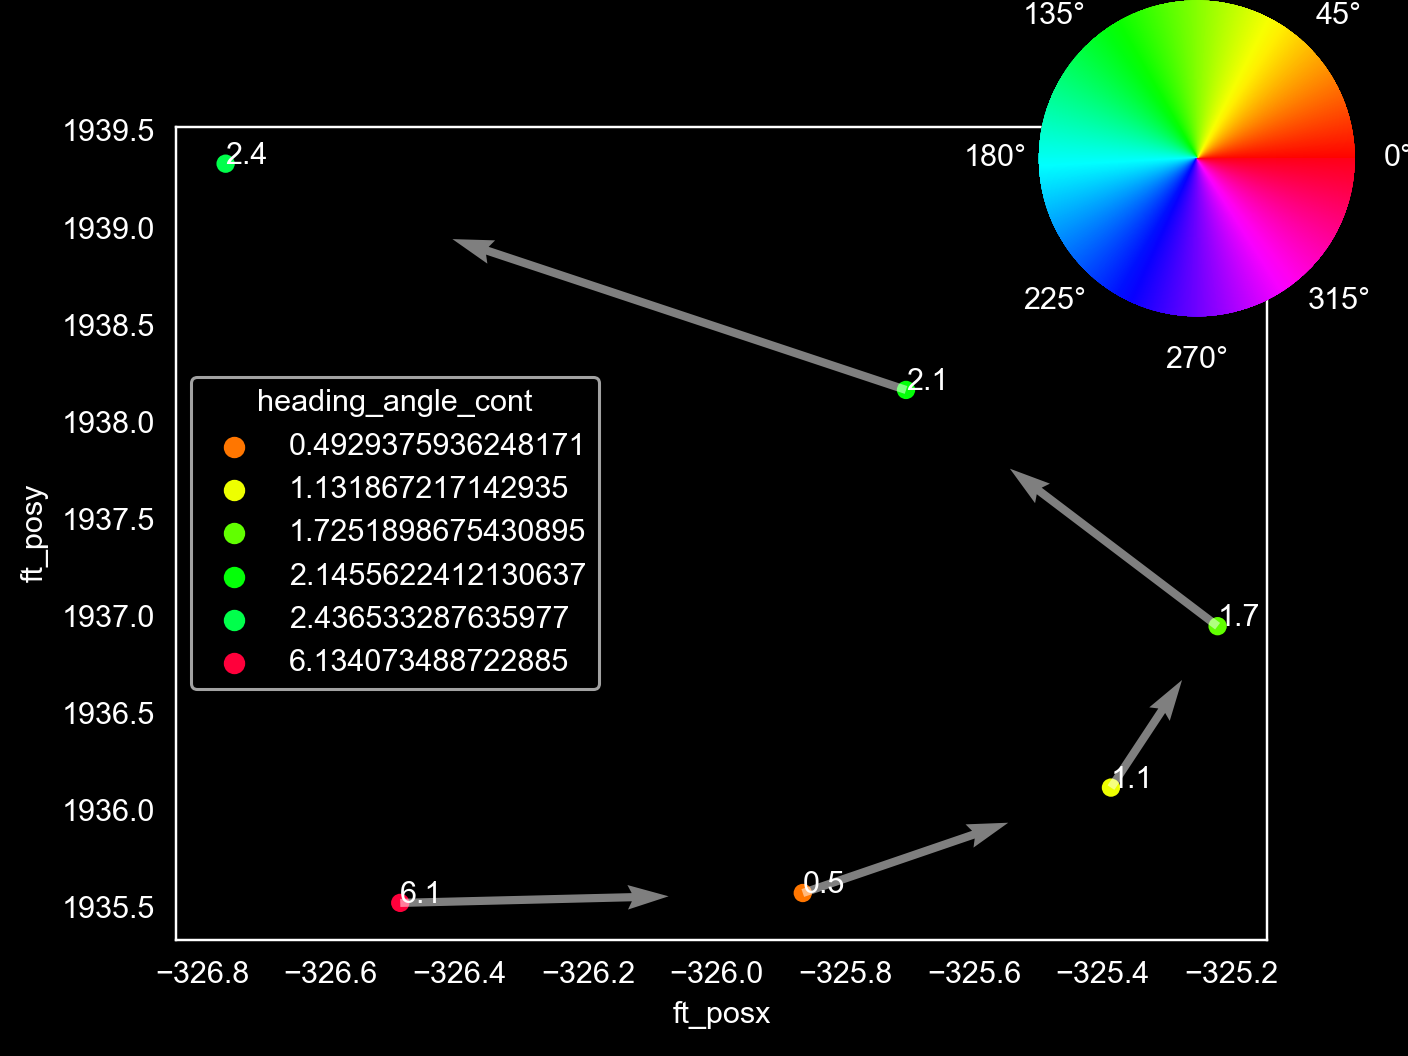

<PolarAxes: >

In [120]:
cmap='hsv'
plot_var = heading_var_cont if use_cont else heading_var
plotdf = df[df['boutnum']==15]
fig, ax = pl.subplots()
sns.scatterplot(x='ft_posx', y='ft_posy', hue=plot_var, data=plotdf, ax=ax, 
                edgecolor='none', palette=cmap, hue_norm=theta_norm)
for i, row_ in plotdf.iterrows():
    ax.text(row_['ft_posx'], row_['ft_posy'], '{:.1f}'.format(row_[plot_var]))
    
x, y, uu, vv = butil.get_quiverplot_inputs(plotdf)
ax.quiver(plotdf['ft_posx'].values, plotdf['ft_posy'].values, uu, vv, #color=colormap(norm(colors)), 
          angles='xy', scale_units='xy', scale=1.5, alpha=0.5, color='w')
util.add_colorwheel(fig, cmap=cmap, axes=[0.7, 0.7, 0.3, 0.3], 
                    theta_range=theta_range, theta_units=theta_units, deg2plot=None)

In [88]:
del_t = np.mean(np.diff(df.seconds))
effective_rate = 1/del_t
    
xv = np.gradient(df['ft_posx'])/df['time'].diff() # *effective_rate
yv = np.gradient(df['ft_posy'])/df['time'].diff() #*effective_rate
speed = np.sqrt(xv**2+yv**2)

<IPython.core.display.Javascript object>


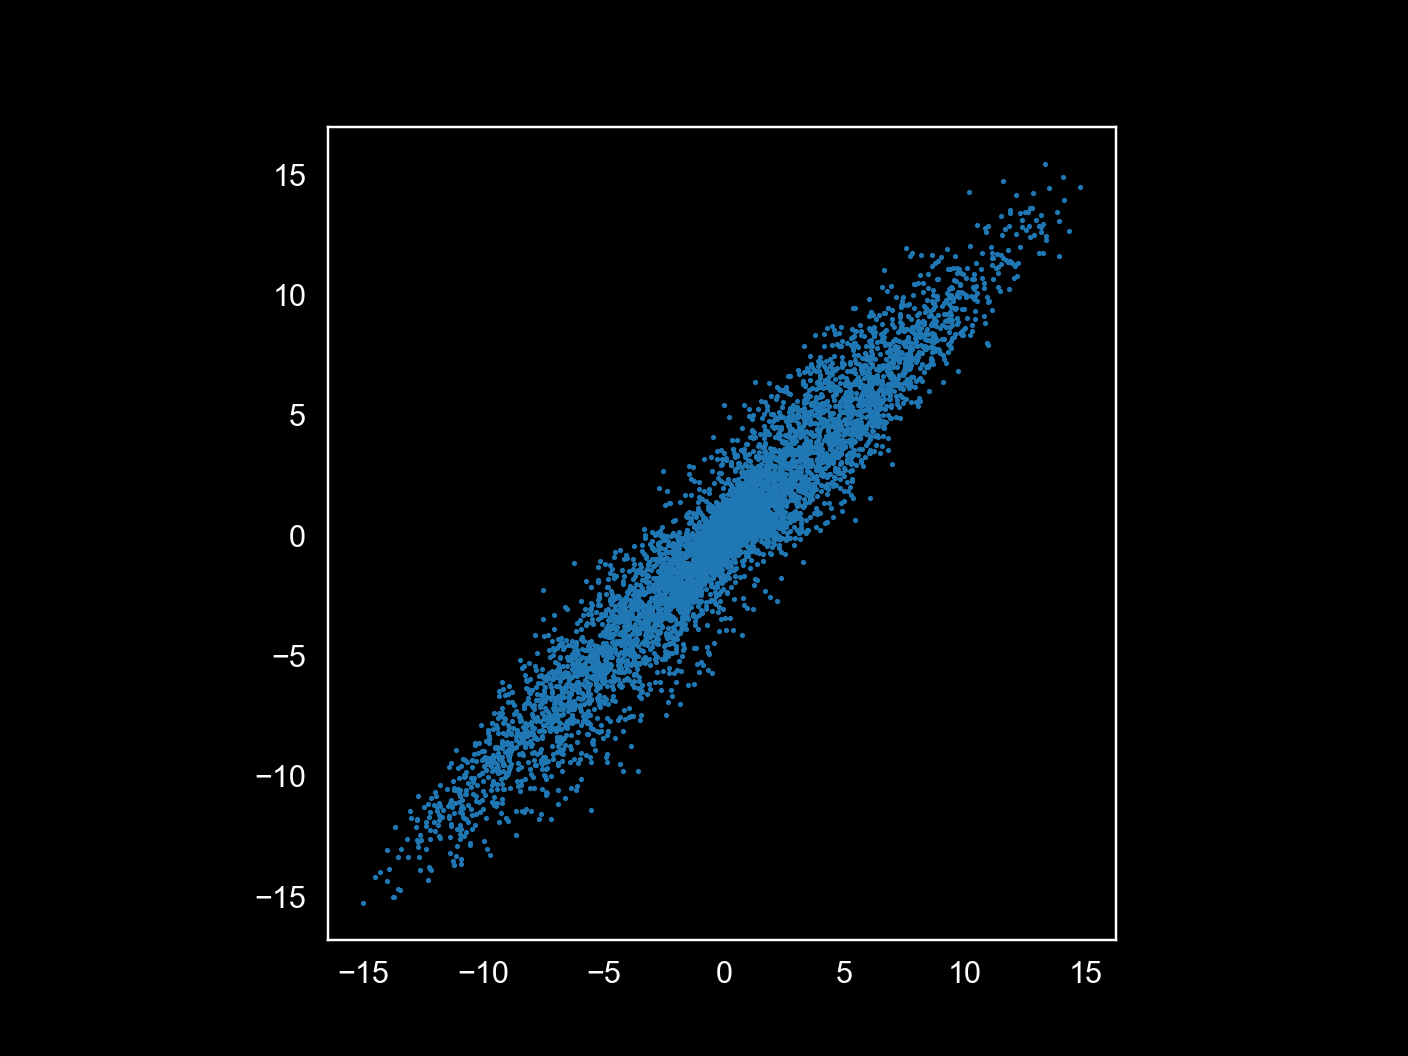

In [64]:
xv1 = np.gradient(df['ft_posx'])*effective_rate
xv2 = df['ft_posx'].diff()/df['time'].diff()
fig, ax = pl.subplots()
ax.scatter(xv, xv2, s=0.5)
ax.set_aspect('equal')

<IPython.core.display.Javascript object>


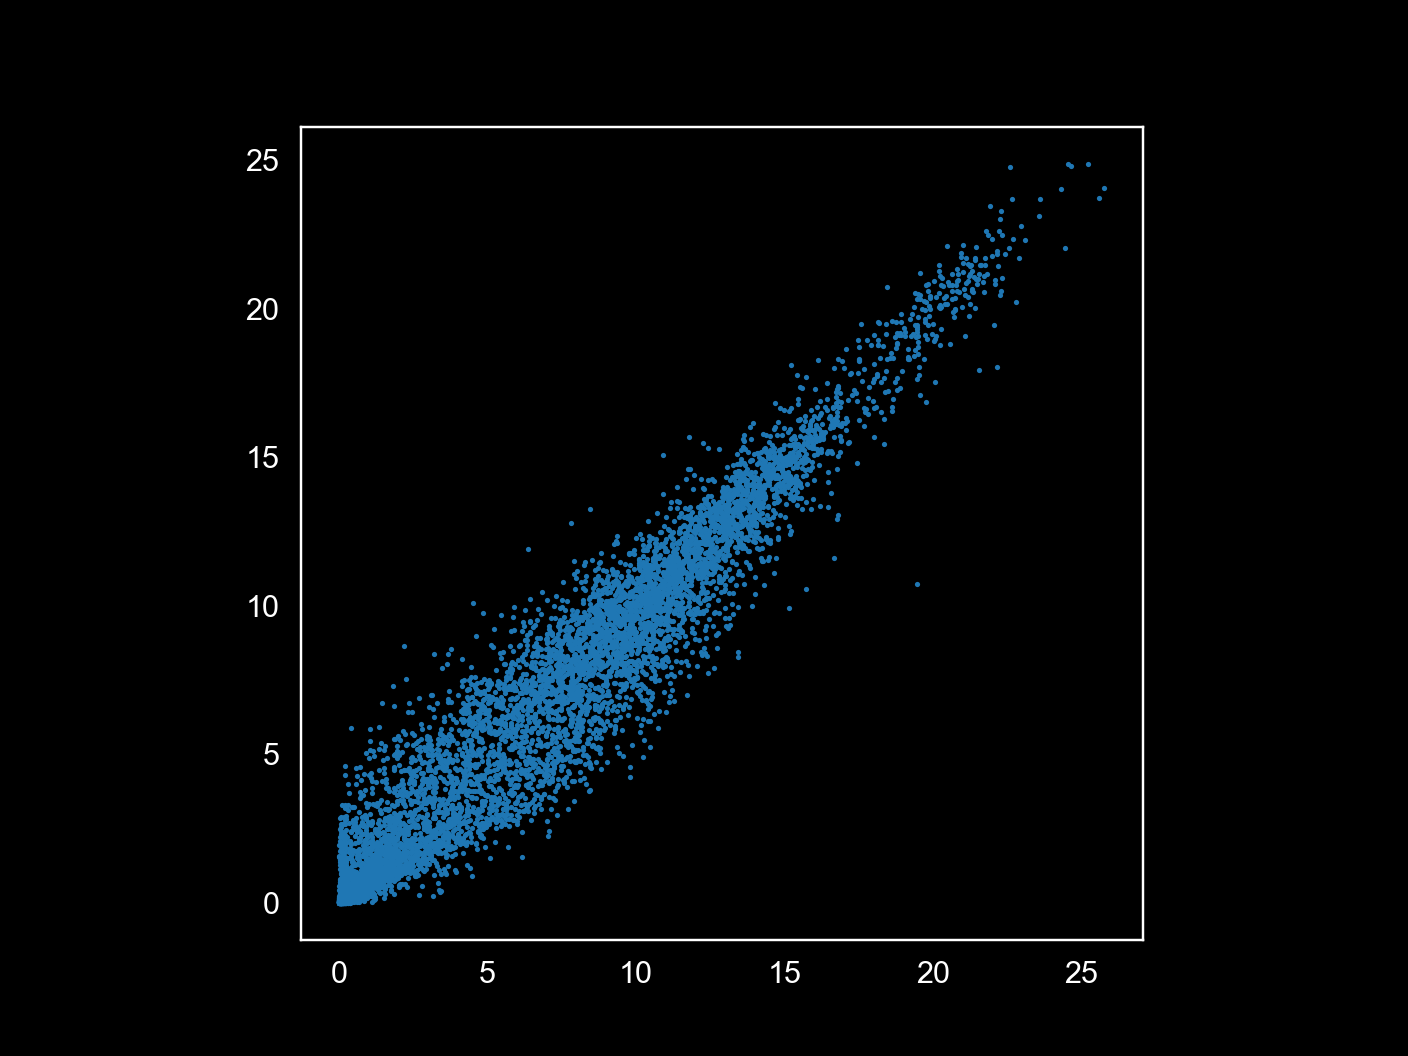

In [61]:
fig, ax= pl.subplots()
ax.scatter(df['speed'], speed, s=0.5)
ax.set_aspect('equal')

## turning distns when stopped

In [57]:
ogrid

{'c1098': (-117.27972442575403, -107.166057760788),
 'c2804': (-327.1692030306531, -317.16725622282),
 'c7597': (-117.31416827280732, -107.166057760788)}

In [626]:
si = 2804
ei = 7596
outdf = df[~df['instrip']].loc[si:ei].copy()
outdf['boutnum'].unique()

array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35])

In [641]:
df1 = outdf[outdf['boutnum']<35].copy()

<IPython.core.display.Javascript object>


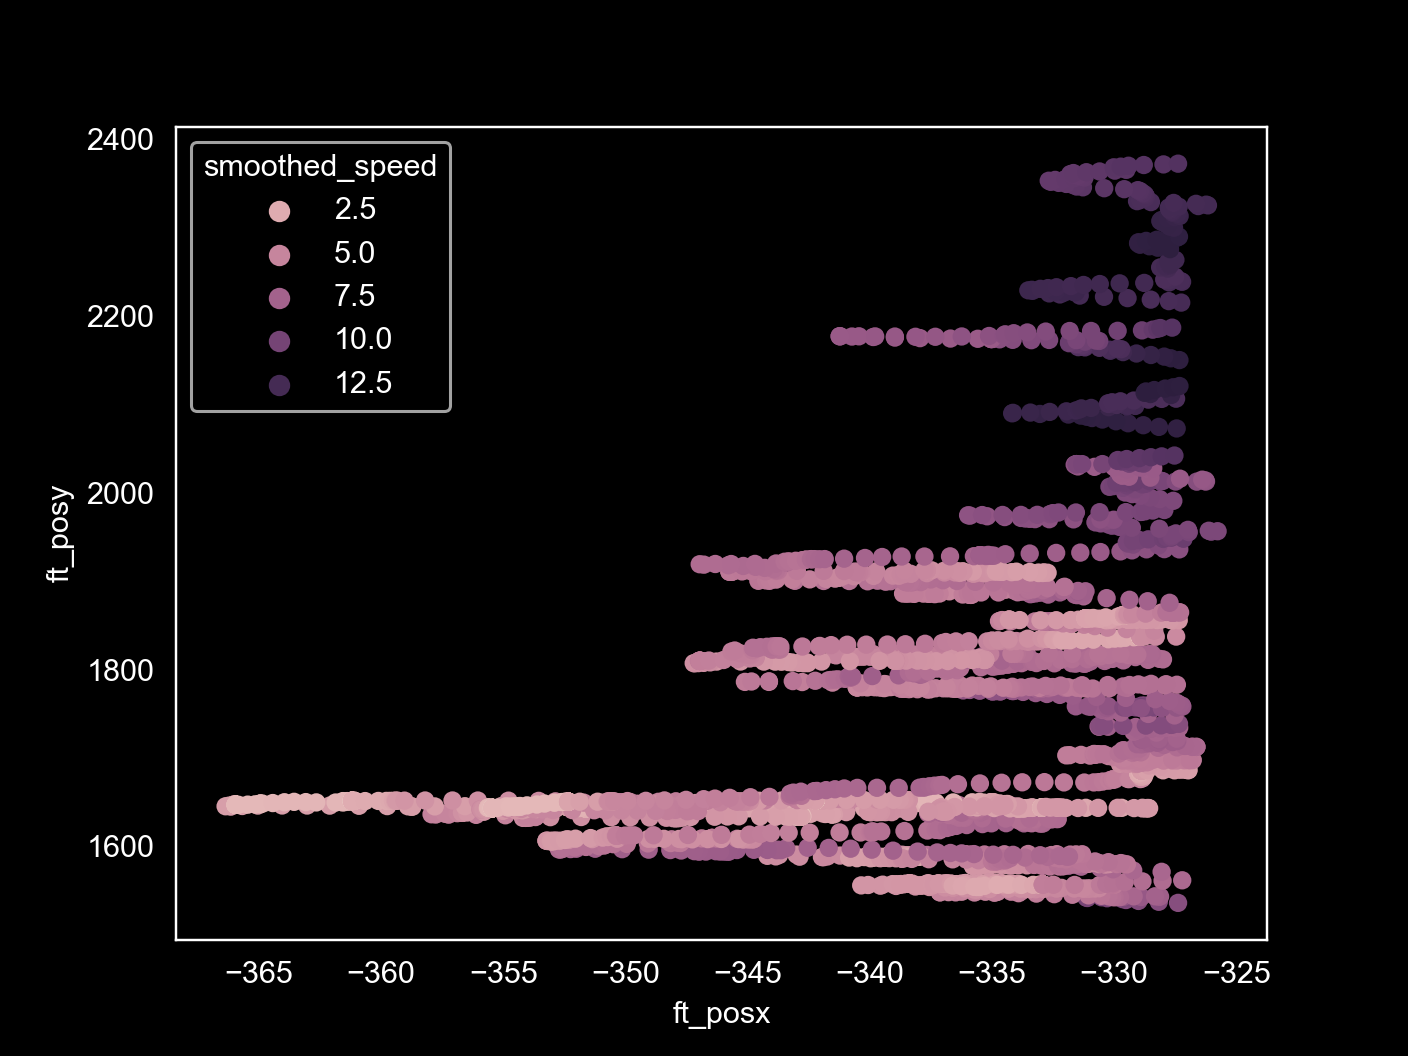

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [642]:
fig, ax = pl.subplots()
sns.scatterplot(data=df1, x='ft_posx', y='ft_posy', hue='smoothed_speed',
                ax=ax,edgecolor='none')

In [820]:
df1['boutnum'].unique()

array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33])

In [822]:

n_=[]
for bnum, df_ in df1[df1['stopped']].groupby(['boutnum']):
    print(bnum, len(df_['stopbout'].unique()))
    n_.append(len(df_['stopbout'].unique()))
np.sum(n_)

7 5
11 1


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_54135/1754293066.py:2: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



6

In [816]:
df1[df1['stopped']]['stopbout'].unique()

array([14, 16, 18, 20, 22, 24])

In [823]:
plotdf = df1[df1['boutnum']==7]
stopbout_nums = plotdf[plotdf['stopped']]['stopbout'].unique()
stopbout_nums

array([14, 16, 18, 20, 22])

In [827]:
s_ = plotdf[plotdf['stopped']].groupby(['stopbout']).get_group(14)
stop_start, stop_end = s_.iloc[0].name, s_.iloc[-1].name
stop_pos = s_['ft_posx'].mean(), s_['ft_posy'].mean()
currstop = plotdf.loc[stop_start-50:stop_end+50].copy()

In [869]:
import math

<IPython.core.display.Javascript object>


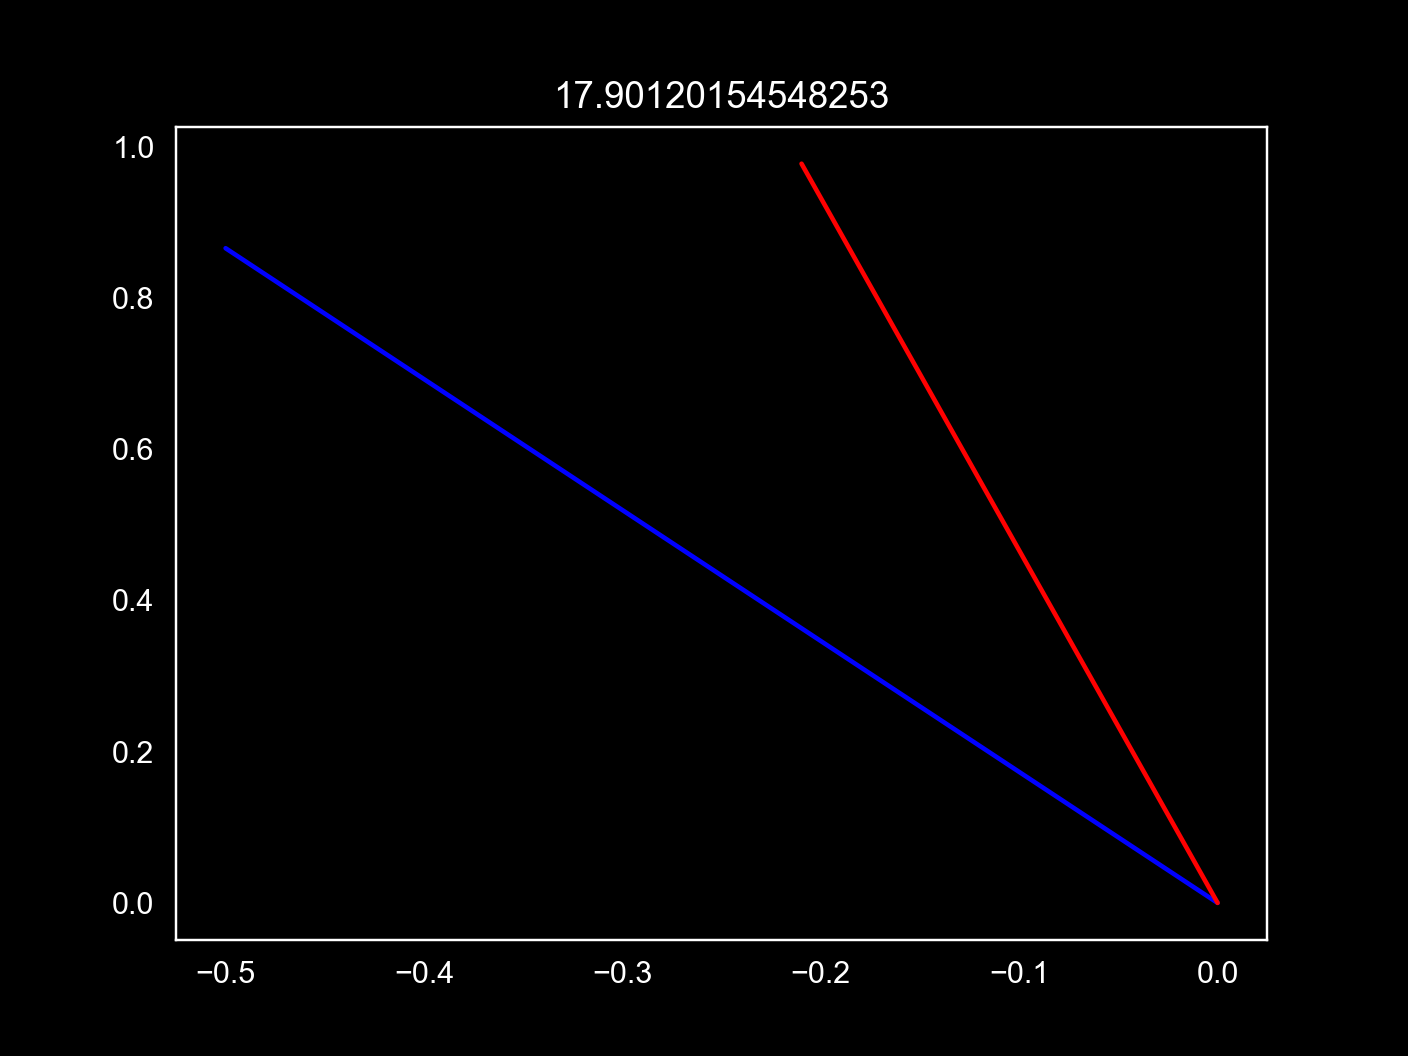

Text(0.5, 1.0, '17.90120154548253')

In [870]:
uvec0 = (u.values[0], v.values[0])/np.linalg.norm((u.values[0], v.values[0]))
uvec1 = (u.values[1], v.values[1])/np.linalg.norm((u.values[1], v.values[1]))
theta = math.atan2(uvec0[1], uvec0[0]) - math.atan2(uvec1[1], uvec1[0])

fig, ax = pl.subplots()
ax.plot([0, uvec0[0]], [0, uvec0[1]], 'b')
ax.plot([0, uvec1[0]], [0, uvec1[1]], 'r')
ax.set_title('{}'.format(np.rad2deg(theta)))

In [878]:
dirvecs = pd.DataFrame({'u': u, 'v': v})
dirvecs['norm'] = np.linalg.norm(dirvecs[['u', 'u']], axis=1)

ValueError: not enough values to unpack (expected 3, got 1)

In [880]:
uvecs = [(i, j)/k for i, j, k in dirvecs[['u', 'v', 'norm']].values]

In [884]:
dirvecs[['u', 'v']].apply(math.atan2, axis=1)

TypeError: atan2 expected 2 arguments, got 1

In [ ]:
theta = math.atan2(dirvecs['u'], uvec0[0]) - math.atan2(uvec1[1], uvec1[0])


<IPython.core.display.Javascript object>


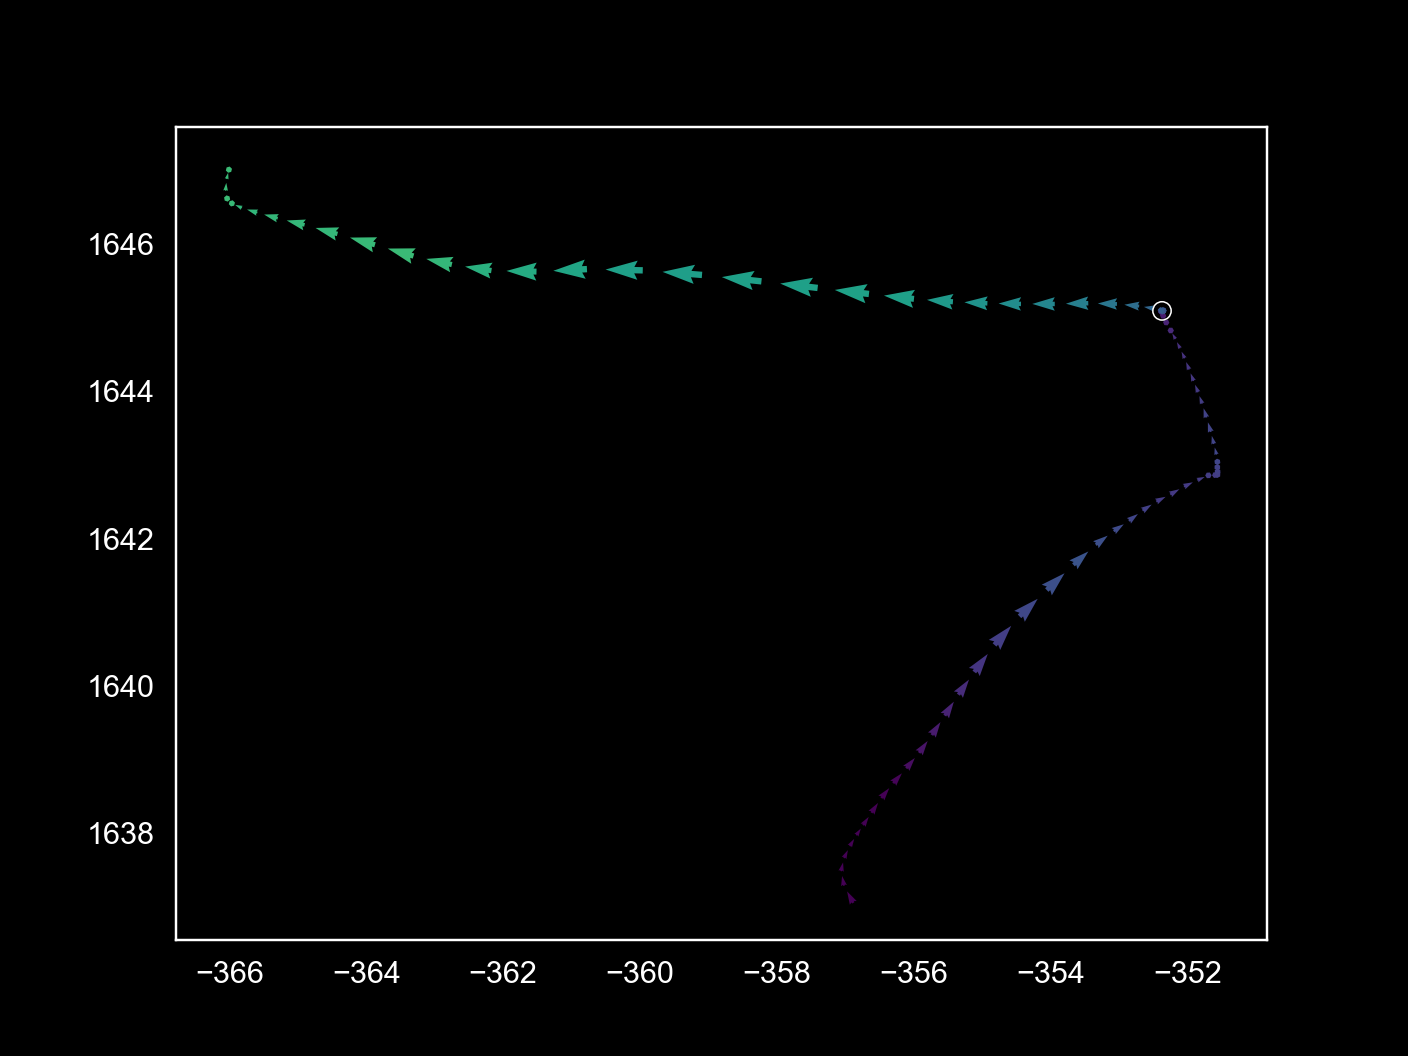

In [828]:
fig, ax = pl.subplots()
x, y, u, v = butil.get_quiverplot_inputs(currstop,
                                        xvar='smoothed_x', yvar='smoothed_y')
ax.quiver(x, y, u, v, color=colormap(norm(colors)), 
          angles='xy', scale_units='xy', scale=1.5)
ax.scatter(stop_pos[0], stop_pos[1], marker='o', edgecolor='w', facecolor='none',
          lw=0.5)

In [797]:
nsec_pre = 5
nsec_post = 5

target_tstart = plotdf.loc[stop_start]['time'] - nsec_pre
target_tend = plotdf.loc[stop_start]['time'] + nsec_post
pre_idx = plotdf['time'].sub(target_tstart).abs().idxmin()
post_idx = plotdf['time'].sub(target_tend).abs().idxmin()

In [798]:
pre = plotdf.loc[pre_idx:stop_start]
x0, y0, u0, v0 = butil.get_quiverplot_inputs(pre, xvar='smoothed_x', yvar='smoothed_y')
pre_u, pre_v = u0.sum(), v0.sum()
pre_x, pre_y = x0[-1], y0[-1]

post = plotdf.loc[stop_start:post_idx]
x1, y1, u1, v1 = butil.get_quiverplot_inputs(post, xvar='smoothed_x', yvar='smoothed_y')
post_u, post_v = u1.sum(), v1.sum()
post_x, post_y = x1[0], y1[0]

(0.17921389486099315, 0.9222233028967821)

<IPython.core.display.Javascript object>


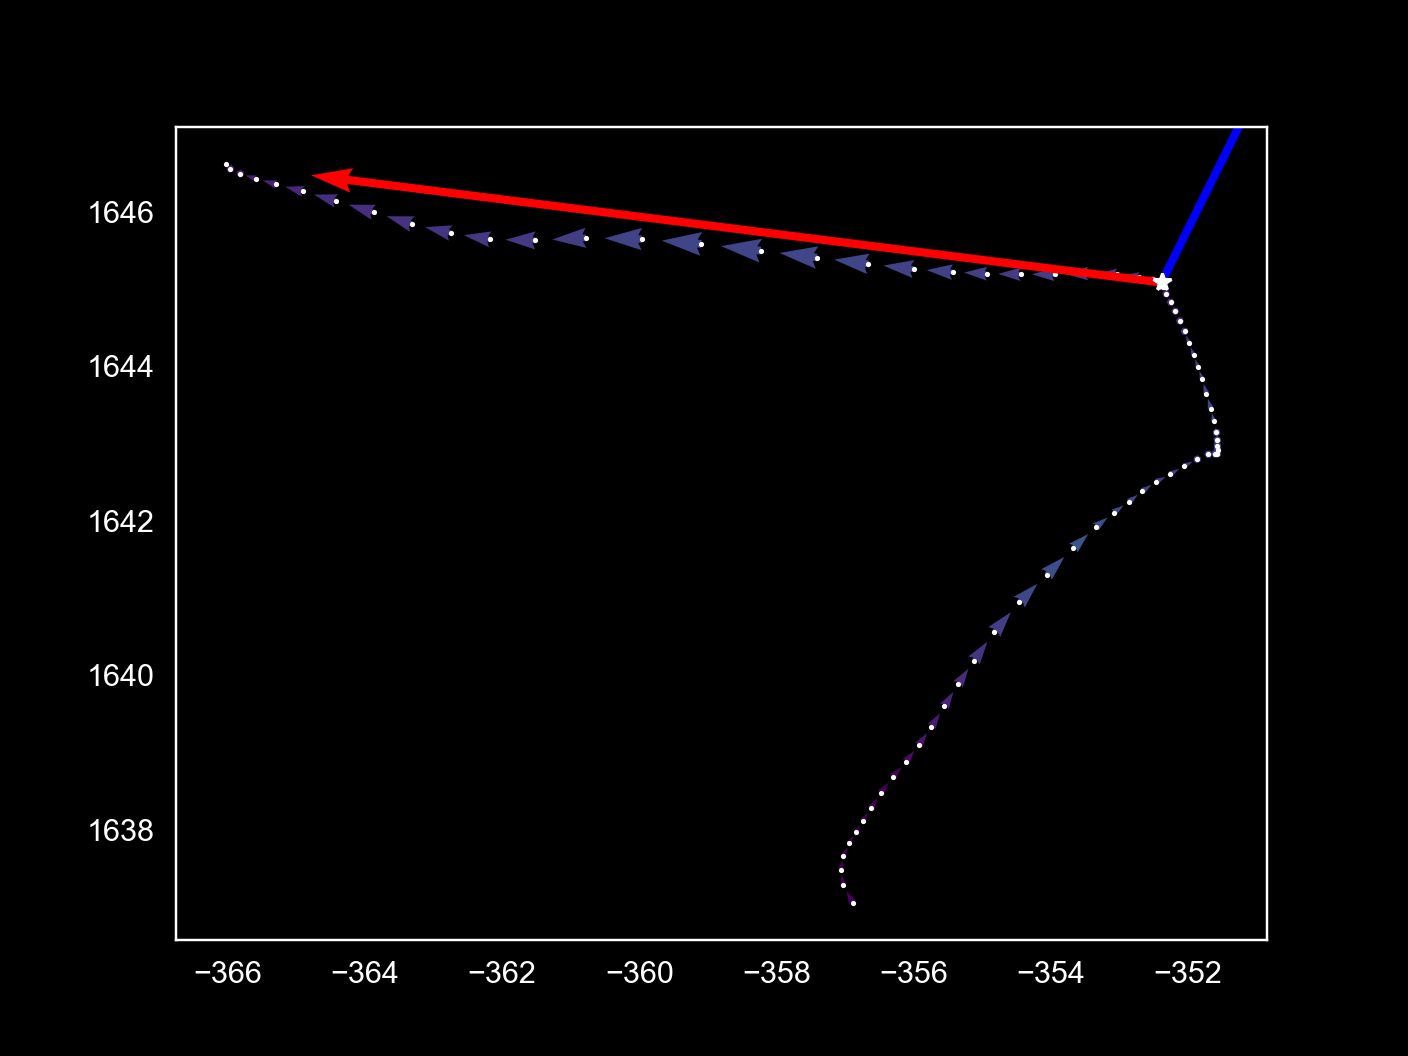

In [799]:
# PRE
ax.quiver(x0, y0, u0, v0, color=colormap(norm(colors)), 
          angles='xy', scale_units='xy', scale=1.5)
ax.scatter(x0, y0, s=0.5, c='w')
ax.quiver(pre_x, pre_y, pre_u, pre_v, color='b',
          angles='xy', scale_units='xy', scale=1.1)
# Post
ax.quiver(x1, y1, u1, v1, color=colormap(norm(colors)), 
          angles='xy', scale_units='xy', scale=1.5)
ax.scatter(x1, y1, s=0.5, c='w')
ax.quiver(post_x, post_y, post_u, post_v, color='r',
          angles='xy', scale_units='xy', scale=1.1)
# stop pos
ax.plot(stop_pos[0], stop_pos[1], 'w*')

In [802]:
nsec_pre = 3
nsec_post = 3

In [804]:
plotdf[plotdf['stopped']]['stopbout'].unique()

array([14, 16, 18, 20, 22])

<IPython.core.display.Javascript object>


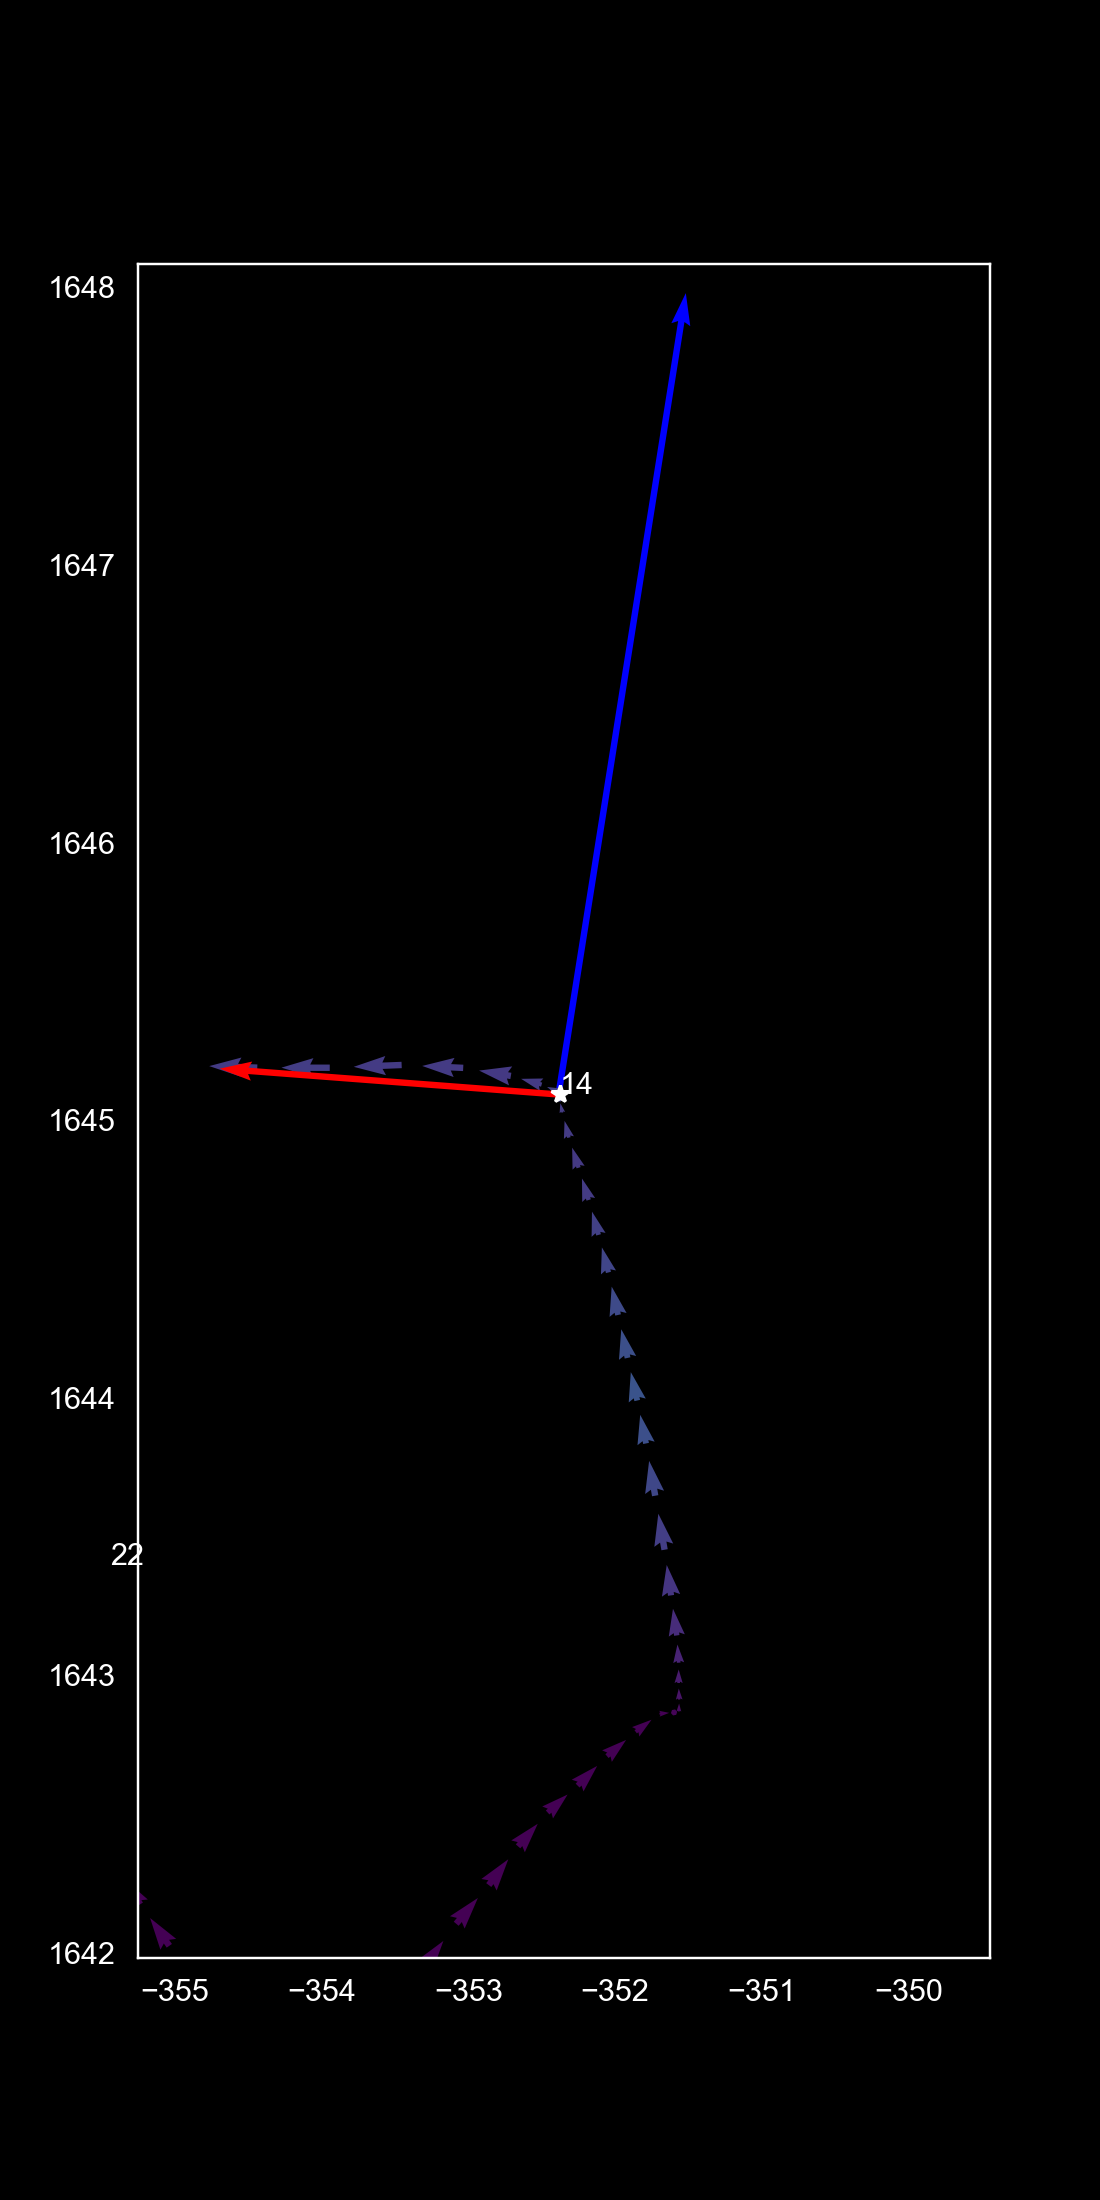

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_54135/1389984495.py:4: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [818]:
plotdf = df1.copy()
fig, ax = pl.subplots(figsize=(5, 10))

for stopnum, s_ in plotdf[plotdf['stopped']].groupby(['stopbout']):
    stop_start, stop_end = s_.iloc[0].name, s_.iloc[-1].name
    stop_pos = s_['ft_posx'].mean(), s_['ft_posy'].mean()
    # get pre/post ixs
    target_tstart = plotdf.loc[stop_start]['time'] - nsec_pre
    target_tend = plotdf.loc[stop_start]['time'] + nsec_post
    pre_idx = plotdf['time'].sub(target_tstart).abs().idxmin()
    post_idx = plotdf['time'].sub(target_tend).abs().idxmin()
    # Get avg vectors
    pre = plotdf.loc[pre_idx:stop_start]
    x0, y0, u0, v0 = butil.get_quiverplot_inputs(pre, xvar='smoothed_x', yvar='smoothed_y')
    pre_u, pre_v = u0.sum(), v0.sum()
    pre_x, pre_y = x0[-1], y0[-1]

    post = plotdf.loc[stop_start:post_idx]
    x1, y1, u1, v1 = butil.get_quiverplot_inputs(post, xvar='smoothed_x', yvar='smoothed_y')
    post_u, post_v = u1.sum(), v1.sum()
    post_x, post_y = x1[0], y1[0]

    # PRE
    ax.quiver(x0, y0, u0, v0, color=colormap(norm(colors)), 
              angles='xy', scale_units='xy', scale=1.5)
    #ax.scatter(x0, y0, s=0.5, c='w')
    ax.quiver(pre_x, pre_y, pre_u, pre_v, color='b',
              angles='xy', scale_units='xy', scale=1.1)
    # Post
    ax.quiver(x1, y1, u1, v1, color=colormap(norm(colors)), 
              angles='xy', scale_units='xy', scale=1.5)
    #ax.scatter(x1, y1, s=0.5, c='w')
    ax.quiver(post_x, post_y, post_u, post_v, color='r',
              angles='xy', scale_units='xy', scale=1.1)
    # stop pos
    ax.plot(stop_pos[0], stop_pos[1], 'w*')
    ax.text(stop_pos[0], stop_pos[1], '{}'.format(stopnum), color='w')

5.0

In [521]:
# plot all bouts
# --------------------------------------------------------
start_at_odor=True
hue_varname='boutnum'
nbouts_plot=20
palette='viridis'
#plotdf = df[df['time']>=odor_start_time] if start_at_odor else df.copy()
#plotdf = plotdf[plotdf['boutnum']<=nbouts_plot].copy() #[df0['time']>=odor_start_time].copy()
# --------------------------------------------------------
# fig, ax = pl.subplots(figsize=(8,6))
# sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue=hue_varname, palette=palette,
#                s=3, ax=ax, edgecolor='none')
# ax.plot(odor_start_posx, odor_start_posy, 'w*', markersize=10) 
# ax.axvline(x=odor_xmin, c=odor_lc, lw=odor_lw) 
# ax.axvline(x=odor_xmax, c=odor_lc, lw=odor_lw) 
# if not start_at_odor:
#     ax.axhline(odor_start_posy, 'w:')
# ax.legend(bbox_to_anchor=(1,1), loc='upper left', title=hue_varname, frameon=False)
# ax.set_title('{}/{}'.format(experiment, fn))